In [53]:
import scvelo as scv
import pandas as pd
import numpy as np
import os, tqdm
import matplotlib.pyplot as plt


In [59]:
data_location = 'server'
# data_location = 'local'
n=0

# define colors for plotting
colors = {
    '24h': ["#00688B","#708090","#B2DFEE","#7EC0EE","#8B3A62","#A2B5CD","#27408B","#000000","#4D4D4D"],
    '48h': ["#7EC0EE","#708090","#4682B4","#8B3A62","#A2B5CD","#27408B","#CD5555","#7A7A7A","#D1EEEE","#000000"],
    '72h': ["#27408B","#104E8B","#4682B4","#8B3A62","#7EC0EE","#708090","#A2B5CD","#8B008B","#CD5555","#FF69B4"]
    }

ages = ["24h","48h","72h"]
if data_location=='server':
    folders = [ os.path.join("Y:",os.sep,"Nicola_Gritti","analysis_code","scRNAseq_Gastruloids","new_codes","data","for_scvelo",age) for age in ages ]
    outfolder = os.path.join("Y:",os.sep,"Nicola_Gritti","analysis_code","scRNAseq_Gastruloids","new_codes","results","rnavelocity")
elif data_location=='local':
    folders = [ os.path.join("F:",os.sep,"scrnaseq_gastruloids","BAMS_scRNAseq",age) for age in ages ]
    outfolder = os.path.join("F:",os.sep,"scrnaseq_gastruloids","results","rnavelocity")


In [60]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


In [61]:
folder = folders[n]

samples = []

for n, folder in tqdm.tqdm(enumerate(folders)):
#     print(os.path.join(folder,'scvelo'+ages[n]+'.h5ad'))

    if not os.path.exists(os.path.join(folder,'scvelo'+ages[n]+'.h5ad')):
        sample_obs = pd.read_csv(os.path.join(folder,"cellID_obs.csv")).x.values
        sample_obs = [i[:16] for i in sample_obs]
        # print(sample_obs[0])
        umap = pd.read_csv(os.path.join(folder,"cell_embeddings.csv"))
        cell_clusters = pd.read_csv(os.path.join(folder,"clusters.csv"))

        sample_one = scv.read(os.path.join(folder,"possorted_genome_bam.loom"), cache=True)

        ### filter based on cell id
        cell_id = [i.split(":")[-1][:-1] for i in sample_one.obs.index.values]
        # print(cell_id[0])
        sample_one.obs.index = cell_id
        idx = [i in sample_obs for i in cell_id]
        sample_one = sample_one[idx]

        ### change column name
        sample_one_index = pd.DataFrame(sample_one.obs.index)
        sample_one_index = sample_one_index.rename(columns = {0:'Cell ID'})

        umap = umap.rename(columns = {'Unnamed: 0':'Cell ID'})
        umap['Cell ID'] = [i[:16] for i in umap['Cell ID'].values]
        # print(umap)
        umap_ordered = sample_one_index.merge(umap,on="Cell ID")

        cell_clusters = cell_clusters.rename(columns = {'Unnamed: 0':'Cell ID'})
        cell_clusters['Cell ID'] = umap['Cell ID'].values
        colors_ordered = sample_one_index.merge(cell_clusters,on="Cell ID")
        sample_one.uns['Cluster_colors'] = colors_ordered.x.values

        umap_ordered = umap_ordered.iloc[:,1:]
        sample_one.obsm['X_umap'] = umap_ordered.values

        scv.pp.filter_and_normalize(sample_one, n_top_genes=2000)
        scv.pp.moments(sample_one)#, n_pcs=30, n_neighbors=30)
        scv.tl.velocity(sample_one, mode = "stochastic")
        scv.tl.velocity_graph(sample_one)

        sample_one.write(os.path.join(folder,'scvelo'+ages[n]+'.h5ad'))
        samples.append(sample_one)

    else:
        sample_one = scv.read(os.path.join(folder, 'scvelo'+ages[n]+'.h5ad'))
        samples.append(sample_one)


0it [00:00, ?it/s]

Y:\Nicola_Gritti\analysis_code\scRNAseq_Gastruloids\new_codes\data\for_scvelo\24h\scvelo24h.h5ad


1it [00:01,  1.64s/it]

Y:\Nicola_Gritti\analysis_code\scRNAseq_Gastruloids\new_codes\data\for_scvelo\48h\scvelo48h.h5ad


2it [00:03,  1.94s/it]

Y:\Nicola_Gritti\analysis_code\scRNAseq_Gastruloids\new_codes\data\for_scvelo\72h\scvelo72h.h5ad


3it [00:05,  1.81s/it]


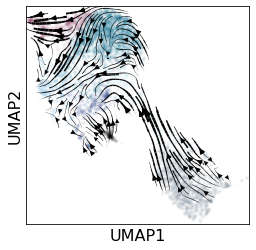

In [65]:
# scv.pl.velocity_embedding(sample_one, basis='umap', color=sample_one.uns['Cluster_colors'], color_map='cool')
# scv.pl.velocity_graph(sample_one, basis = 'umap', color=sample_one.uns['Cluster_colors'])
# scv.pl.velocity_embedding_grid(sample_one, basis = 'umap', color=sample_one.uns['Cluster_colors'])

fig, ax = plt.subplots(figsize=(4,4))
scv.pl.velocity_embedding_stream(samples[0], basis = 'umap', 
                                color=samples[0].uns['Cluster_colors'], 
#                                     color_map=['#%02x%02x%02x' % tuple((255*np.array(lighten_color(i,0.3))).astype(int)) for i in colors[ages[n]]],
                                color_map=colors[ages[0]],
                                size=50,
                                alpha=.1,
                                linecolor='k',
                                linewidth=1.5,
                                frameon=True,
                                colorbar=False,
                                dpi=300,
                                # add_outline=True,
                                ax=ax,
                                fontsize=16)
                                    
fig.savefig(os.path.join(outfolder, 'velocity_embedding_stream24h.png'), dpi=600)


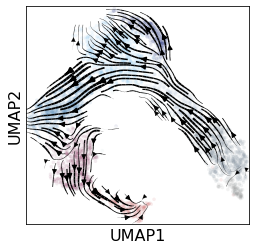

In [66]:
# scv.pl.velocity_embedding(sample_one, basis='umap', color=sample_one.uns['Cluster_colors'], color_map='cool')
# scv.pl.velocity_graph(sample_one, basis = 'umap', color=sample_one.uns['Cluster_colors'])
# scv.pl.velocity_embedding_grid(sample_one, basis = 'umap', color=sample_one.uns['Cluster_colors'])

fig, ax = plt.subplots(figsize=(4,4))
scv.pl.velocity_embedding_stream(samples[1], basis = 'umap', 
                                color=samples[1].uns['Cluster_colors'], 
#                                     color_map=['#%02x%02x%02x' % tuple((255*np.array(lighten_color(i,0.3))).astype(int)) for i in colors[ages[n]]],
                                color_map=colors[ages[1]],
                                size=50,
                                alpha=.1,
                                linecolor='k',
                                linewidth=1.5,
                                frameon=True,
                                colorbar=False,
                                dpi=300,
                                # add_outline=True,
                                ax=ax,
                                fontsize=16)
                                    
fig.savefig(os.path.join(outfolder, 'velocity_embedding_stream48h.png'), dpi=600)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


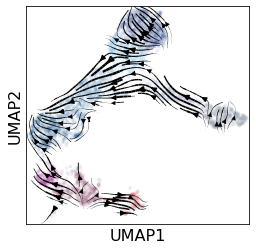

In [67]:
# scv.pl.velocity_embedding(sample_one, basis='umap', color=sample_one.uns['Cluster_colors'], color_map='cool')
# scv.pl.velocity_graph(sample_one, basis = 'umap', color=sample_one.uns['Cluster_colors'])
# scv.pl.velocity_embedding_grid(sample_one, basis = 'umap', color=sample_one.uns['Cluster_colors'])

fig, ax = plt.subplots(figsize=(4,4))
scv.pl.velocity_embedding_stream(samples[2], basis = 'umap', 
                                color=samples[2].uns['Cluster_colors'], 
#                                     color_map=['#%02x%02x%02x' % tuple((255*np.array(lighten_color(i,0.3))).astype(int)) for i in colors[ages[n]]],
                                color_map=colors[ages[2]],
                                size=50,
                                alpha=.1,
                                linecolor='k',
                                linewidth=1.5,
                                frameon=True,
                                colorbar=False,
                                dpi=300,
                                # add_outline=True,
                                ax=ax,
                                fontsize=16)
                                    
fig.savefig(os.path.join(outfolder, 'velocity_embedding_stream72h.png'), dpi=600)
